# 특정 주식 추출하기

In [3]:
from flask import Flask, render_template, request, jsonify
import time
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
import pandas as pd
import warnings
# 011000
warnings.filterwarnings('ignore')

main_url = "https://m.stock.naver.com/index.html#/domestic/stock/011000/price"
driver = webdriver.Chrome("C:/driver/chromedriver")
driver.get(main_url)
time.sleep(2)  
driver.implicitly_wait(1) 
driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
driver.implicitly_wait(1) 
driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')

data = []
columns = ['날짜','종가','전일대비','등락률','시가','고가','저가','거래량']
soup = BeautifulSoup(driver.page_source, "lxml" )
boxItems = soup.select("#content > div:nth-child(4) > div:nth-child(3) > div:nth-child(2) > div > div.VTablePrice_article__DfdmT > table > tbody")[0].select('tr')
driver.close()

In [4]:
for boxItem in boxItems:
    a = boxItem.select('td')
    row = dict()
    row = {"등록번호":'011009'}
    for k,v in list(zip(columns,a)):
        row[k] = v.text

    data.append(row)

In [5]:
data = data[::-1]

In [6]:
kospi_df = pd.DataFrame(data)
kospi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   등록번호    40 non-null     object
 1   날짜      40 non-null     object
 2   종가      40 non-null     object
 3   전일대비    40 non-null     object
 4   등락률     40 non-null     object
 5   시가      40 non-null     object
 6   고가      40 non-null     object
 7   저가      40 non-null     object
 8   거래량     40 non-null     object
dtypes: object(9)
memory usage: 2.9+ KB


In [13]:
kospi_df.head(40)

,등록번호,종가,전일대비,등락률,시가,고가,저가,거래량,MA3,MA5,MA10,MA20
날짜,,,,,,,,,,,,
05.20,011009,23200,200200,+0.87%,23500,24900,22350,6934477,NaN,NaN,NaN,NaN
05.21,011009,24350,"1,1501,150",+4.96%,23250,24450,22600,8035430,NaN,NaN,NaN,NaN
05.24,011009,21350,"3,0003,000",-12.32%,23600,23800,20850,5167187,22966.666667,NaN,NaN,NaN
05.25,011009,22150,800800,+3.75%,21400,22650,20100,4905181,22616.666667,NaN,NaN,NaN
05.26,011009,23100,950950,+4.29%,22750,24800,22350,8268615,22200.000000,22830.0,NaN,NaN
05.27,011009,22450,650650,-2.81%,22800,23050,21800,1897283,22566.666667,22680.0,NaN,NaN
05.28,011009,22500,5050,+0.22%,22450,22750,21650,1907694,22683.333333,22310.0,NaN,NaN
05.31,011009,22900,400400,+1.78%,22750,24100,22150,4585144,22616.666667,22620.0,NaN,NaN
06.01,011009,23050,150150,+0.66%,23200,23700,22050,2689803,22816.666667,22800.0,NaN,NaN


In [7]:
for k,v in list(zip(range(0,9),kospi_df)):
    if not k in [0,1,3,4]:
        kospi_df[v] = kospi_df[v].apply(lambda x : int(int(x.replace(',', ''))))

In [8]:
from mpl_finance import candlestick2_ohlc
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from IPython.display import display

kospi_df.reset_index(drop = True,inplace = True)
kospi_df.set_index('날짜',inplace=True)

kospi_df['MA3'] = kospi_df['종가'].rolling(3).mean()
kospi_df['MA5'] = kospi_df['종가'].rolling(5).mean()
kospi_df['MA10'] = kospi_df['종가'].rolling(10).mean()
kospi_df['MA20'] = kospi_df['종가'].rolling(20).mean()
display(kospi_df.head())


C:\Users\Playdata\Anaconda3\lib\site-packages\mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


,등록번호,종가,전일대비,등락률,시가,고가,저가,거래량,MA3,MA5,MA10,MA20
날짜,,,,,,,,,,,,
05.20,011009,23200,200200,+0.87%,23500,24900,22350,6934477,NaN,NaN,NaN,NaN
05.21,011009,24350,"1,1501,150",+4.96%,23250,24450,22600,8035430,NaN,NaN,NaN,NaN
05.24,011009,21350,"3,0003,000",-12.32%,23600,23800,20850,5167187,22966.666667,NaN,NaN,NaN
05.25,011009,22150,800800,+3.75%,21400,22650,20100,4905181,22616.666667,NaN,NaN,NaN
05.26,011009,23100,950950,+4.29%,22750,24800,22350,8268615,22200.000000,22830.0,NaN,NaN


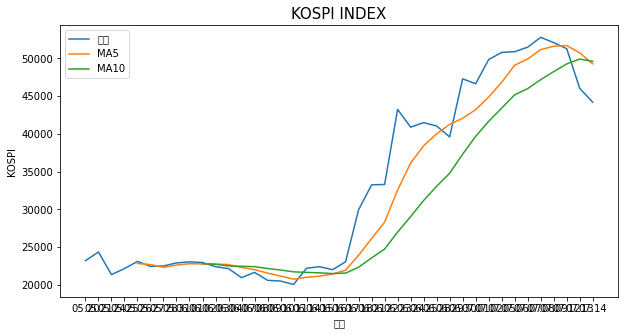

In [9]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title('KOSPI INDEX', fontsize=15)
ax.set_ylabel("KOSPI")
ax.set_xlabel("날짜")
ax.plot(kospi_df.index, kospi_df[['종가','MA5','MA10']])
ax.legend(['종가','MA5','MA10'])
plt.show()

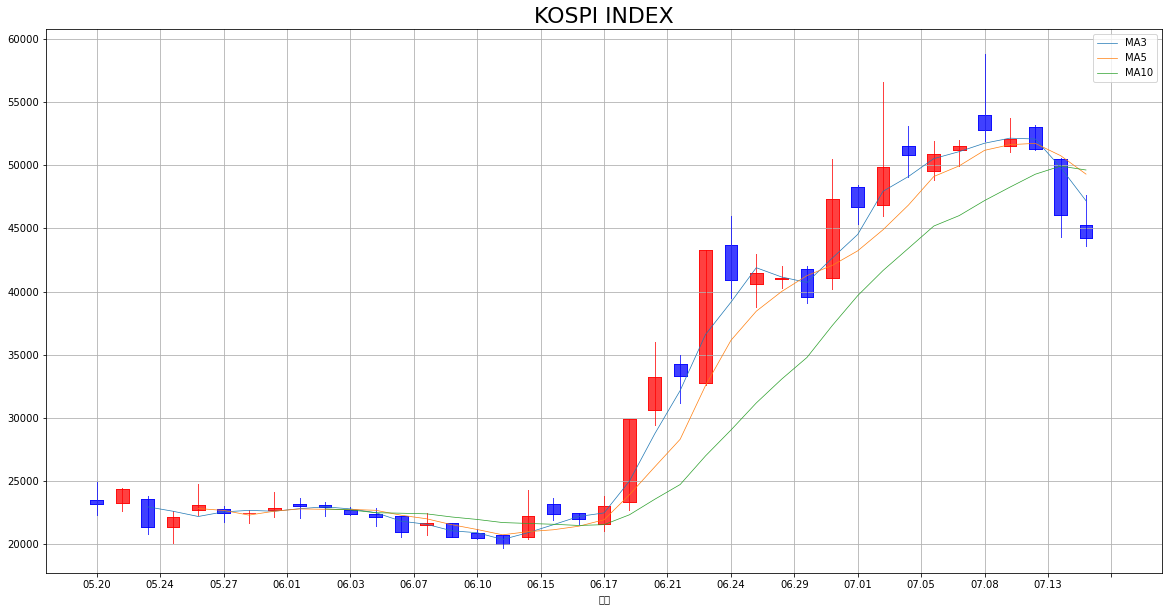

In [10]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
index = kospi_df.index.astype('str') # 캔들스틱 x축이 str로 들어감

# 이동평균선 그리기
ax.plot(index, kospi_df['MA3'], label='MA3', linewidth=0.7)
ax.plot(index, kospi_df['MA5'], label='MA5', linewidth=0.7)
ax.plot(index, kospi_df['MA10'], label='MA10', linewidth=0.7)

# X축 티커 숫자 20개로 제한
ax.xaxis.set_major_locator(ticker.MaxNLocator(20))

# 그래프 title과 축 이름 지정
ax.set_title('KOSPI INDEX', fontsize=22)
ax.set_xlabel('날짜')

# 캔들차트 그리기
candlestick2_ohlc(ax, kospi_df['시가'], kospi_df['고가'], 
                  kospi_df['저가'], kospi_df['종가'],
                  width=0.5, colorup='r', colordown='b')
ax.legend()
plt.grid()
plt.show()

# 특정 주식 종목 뉴스 크롤링

In [26]:
main_url = "https://m.stock.naver.com/index.html#/domestic/stock/005930/news/title"
driver = webdriver.Chrome("C:/driver/chromedriver")
driver.get(main_url)
time.sleep(2)  
news_data = []

for page_num in range(1,5):
    print(page_num,"번째 뉴스 크롤링---------------------")
    time.sleep(3)
    boxItem = driver.find_element_by_css_selector(f"#content > div:nth-child(4) > div:nth-child(3) > div:nth-child(2) > div > div.VNewsList_article__1gx6H > ul > li:nth-child({page_num}) > a")
    boxItem.click()
    time.sleep(3)
    
    a = driver.find_element_by_xpath("/html/body/div[1]/div[1]/div[4]/div[3]/div[2]/div/div[1]/div[1]/strong").text
    b = driver.find_element_by_xpath("/html/body/div[1]/div[1]/div[4]/div[3]/div[2]/div/div[1]/div[2]/div[1]").text
    row = dict()
    row = {"등록번호":'005930'}
    row['제목'] = a
    row['내용'] = b.replace("\n", "")
    news_data.append(row)
    
    time.sleep(3)
    driver.back()
    
driver.close()

1 번째 뉴스 크롤링---------------------
2 번째 뉴스 크롤링---------------------
3 번째 뉴스 크롤링---------------------
4 번째 뉴스 크롤링---------------------


In [29]:
print(news_data)

[{'등록번호': '005930', '제목': '삼성전자, 호찌민 공장 봉쇄명령..하루 171억 손실 위기', '내용': '당국, 근로자 시설내 거주 방안 마련 지시자구안 통과되면 공장 재가동 허용 방침베트남 호찌민에 위치한 삼성전자 SEHC 전경. SEHC 제공[파이낸셜뉴스] 삼성전자 베트남 호찌민 공장에 코로나19 확산으로 인한 봉쇄 행정명령이 내려지면서 하루 170억 원대 손실 위기에 내몰렸다.14일 삼성전자와 외신 등에 따르면 베트남 호찌민 인근 국가전략산업단지인 사이공 하이테크파크(SHTP) 관리위원회는 전일 삼성전자를 비롯한 입주 해외 기업들에게 직원들의 외부 출입을 막고 공장 내 주거 시설을 마련하는 등 대책을 마련하라고 지시했다. 기업들이 제출한 검역계획서와 근로자 거주 안이 통과되지 못하면 공장 가동을 중단해야 한다고 통보했다.삼성전자의 호찌민 가전 복합단지는 TV·모니터·냉장고·세탁기 청소기를 생산하는 사업장으로 임직원은 1만 명가량이다. 공단 관리자 측은 "삼성뿐만 아니라 모든 공장에 검역계획 제출과 직원들이 공장에 머물 수 있는 숙소를 마련할때 까지 임시 폐쇄를 요청했다"며 "그들의 계획을 검토한 후 우리의 요구 사항을 충족하면 다시 열 수 있도록 허용할 것"이라고 밝혔다.SHTP 단지 내에는 현재 삼성전자와 인텔 등 한국과 미국, 유럽, 일본 기업을 포함 약 86개 업체가 입주해 있다. 만일 삼성전자가 제출한 자구안이 당국의 요구 조건을 충족시키지 못해 공장 가동이 중단되면 손실이 불가피하다.지난해 사업보고서 기준 호찌민 생산법인 SEHC(Samsung Electronics HCMC CE Complex)의 연간 매출액은 6조2731만 원이다. 이를 365일 기준으로 산술적으로 나누면 공장을 하루 동안 멈출 경우 대략 171억 원의 손실이 발생한다는 계산이 나온다.이는 지난겨울 폭설로 인해 가동이 중단됐던 미국 텍사스 오스틴 반도체 공장 하루 손실액 100억 원을 훌쩍 뛰어넘는 규모다. 당시 오스틴 공장의 중단이 장기화하면서 최종 손실액은

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
 
content = ""
for i in news_data:
    content += i["내용"]
wordcloud = WordCloud(font_path='font/HMKMMAG.TTF', background_color='white').generate(content)
# news_data[0]["내용"]


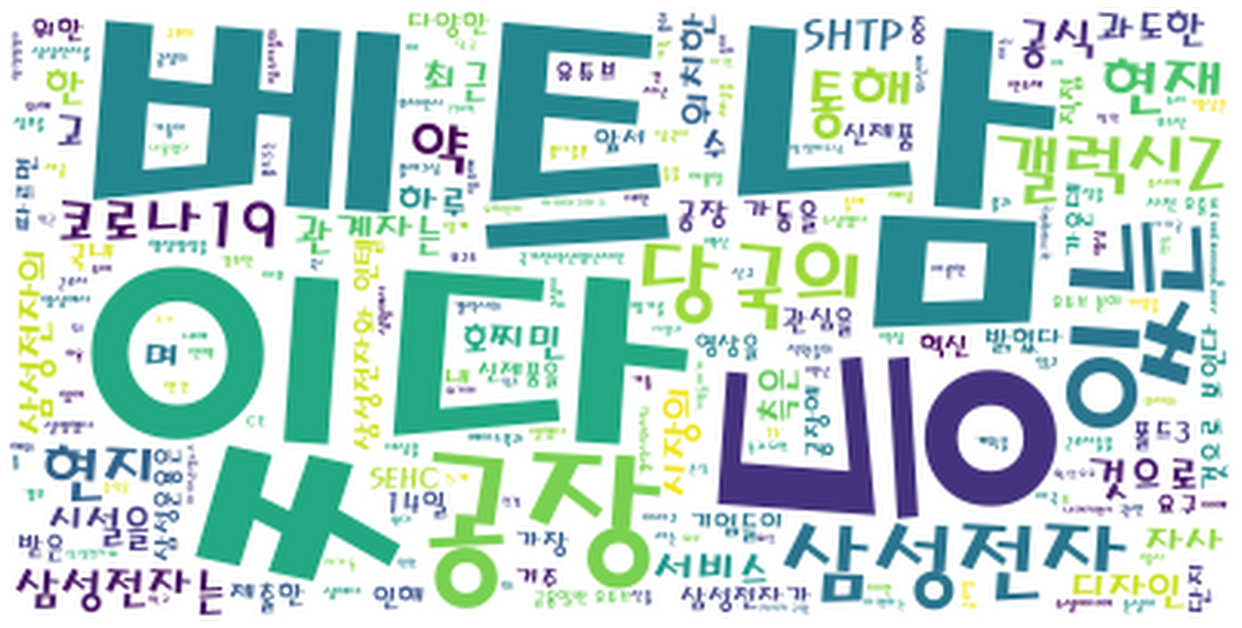

In [31]:
plt.figure(figsize=(22,22)) #이미지 사이즈 지정
plt.imshow(wordcloud, interpolation='lanczos') #이미지의 부드럽기 정도
plt.axis('off') #x y 축 숫자 제거
plt.show() 
# plt.savefig()
